# Gapminder follow-up: Longer life and fewer children ... forever?

*(to understand the motivation behind this notebook, check the Gapminder exercise in my previous notebook)*

__Focus__ In recent years, life expectancy has progressively increased and birth rate has dropped. These vars are correlated negatively.
- What is the time-course of this effect? 
- Is it comparable across different geographic regions? 

To keep things simple, let\'s focus on the __three continents__ with the largest population and number of countries
- Africa (n = 54 countries)
- Asia (n = 44)
- Europe (n = 42)

In [8]:
# Execute this cell to import libraries, define basic functions and load data into DataFrames 
# (several functions are borrowed from earlier notebook)
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import scipy.stats as stats
from scipy.stats import pearsonr
import datetime 

# load COUNTRY / CONTINENT cList (old function)
def importCLIST(): 
    fn = r'https://raw.github.com/tkatus/data/main/countries_per_continent.csv'
    cList = pd.read_csv(fn)
    cList.columns = ['continent', 'country']
    d = {'Congo, Democratic Republic of': 'Congo, Dem. Rep.', 'Burkina': 'Burkina Faso', 'Burma (Myanmar)': 'Myanmar', 'Korea, North': 'North Korea', 'Korea, South': 'South Korea', 'Kyrgyzstan': 'Kyrgyz Republic', 'Russian Federation': 'Russia', 'CZ': 'Czech Republic', 'Macedonia': 'North Macedonia', 'Saint Kitts and Nevis': 'St. Kitts and Nevis', 'Saint Lucia': 'St. Lucia','Saint Vincent and the Grenadines': 'St. Vincent and the Grenadines', 'US': 'United States'}
    cList['country'].replace(to_replace = d, inplace=True)
    cList = cList.set_index('country')
    return cList

# load LIFE EXPECTANCY (old function)
def importAGE(): 
    fn = r'https://raw.github.com/tkatus/data/main/life_expectancy_years.csv'    
    d_age = pd.read_csv(fn)
    d = {'Cote d\'Ivoire': 'Ivory Coast','Congo, Rep.': 'Congo', 'Micronesia, Fed. Sts.': 'Micronesia', 'Lao': 'Laos', 'Slovak Republic': 'Slovakia', 'Eswatini':'Swaziland','Timor-Leste': 'East Timor'}
    d_age.replace(to_replace = d, inplace= True)
    d_age = d_age.set_index('country')
    d_age = d_age.applymap(mapNumbers)
    print('LIFE EXPECTANCY - missing values: {}'.format(d_age.isnull().sum().sum()))
    return d_age 

# load FERTILITY (old function)
def importKIDS(): 
    fn = r'https://raw.github.com/tkatus/data/main/children_per_woman_total_fertility.csv'  
    d_kids = pd.read_csv(fn)
    d = {'Cote d\'Ivoire': 'Ivory Coast','Congo, Rep.': 'Congo', 'Micronesia, Fed. Sts.': 'Micronesia', 'Lao': 'Laos', 'Slovak Republic': 'Slovakia', 'Eswatini':'Swaziland','Timor-Leste': 'East Timor'}
    d_kids.replace(to_replace = d, inplace= True)
    d_kids = d_kids.set_index('country')
    d_kids = d_kids.applymap(mapNumbers)
    print('FERTILITY - missing values: {}'.format(d_kids.isnull().sum().sum()))
    return d_kids


# HELPER FUNCTION to keep numbers in a consistent format (old function)
def mapNumbers(x): # Replaces k and m and makes sure all data is numeric
    if type(x) == str:        
        gr = re.match(r'([0-9.]+$)|([0-9.]+)([kmb]{1}$)', x.lower())     # parse number
        a = gr.groups()
        if not (a[0] is None):
            zed = float(a[0])
        else: 
            if a[2] == 'k':                                              # convert k,m,b
                zed = float(a[1]) * 1000
            elif a[2] == 'm':
                zed = float(a[1]) * 1000000
            elif a[2] == 'b':
                zed = float(a[1]) * 1000000000
    else:
        zed = x
    return zed   


# (new) aggregate timeseries: function calculates mean life exp & birth rate per continent and year
def groupbyContinent(cList, df):
    c = cList.merge(df, how='inner', left_index=True, right_index=True)
    c = c.reset_index()    
    c = c.melt(id_vars = ['country', 'continent'], var_name = "year", value_name = "val")    
    c.year = pd.to_datetime(c.year, format='%Y')
    c = c.set_index('year')
    return c.groupby(['year', 'continent'])['val'].agg('mean')

# RUN: Load and aggregate DATA ====================================================================
print('=' * 100)
cList = importCLIST()
d_age = importAGE()
d_kids = importKIDS()
print('=' * 100)

# create dataframe for scatterplot of vars for different times and continents (observations = continent means)
a = groupbyContinent(cList, d_age)
b = groupbyContinent(cList, d_kids)

new_df = pd.merge(a, b,  how='inner', left_on=['year','continent'], right_on = ['year','continent'])
new_df.columns = ['age', 'kids']
new_df.head(7)

LIFE EXPECTANCY - missing values: 2079
FERTILITY - missing values: 87


age      kids
year       continent                         
1799-01-01 Africa         30.525926  6.397778
           Asia           29.527273  6.328864
           Europe         35.430952  5.499524
           North America  31.100000  5.935714
           Oceania        28.020000  6.263000
           South America  32.950000  6.265833
1800-01-01 Africa         30.400000  6.397778


------

__Correlation SNAPSHOTS__ Plots of life expectancy versus birth rate at four different time points: 100y ago, 50y ago, today, and in 50y (projected).

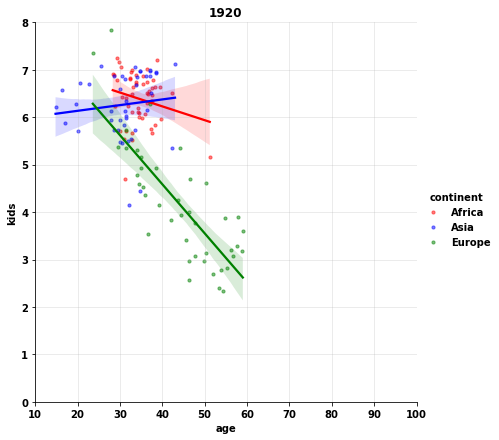

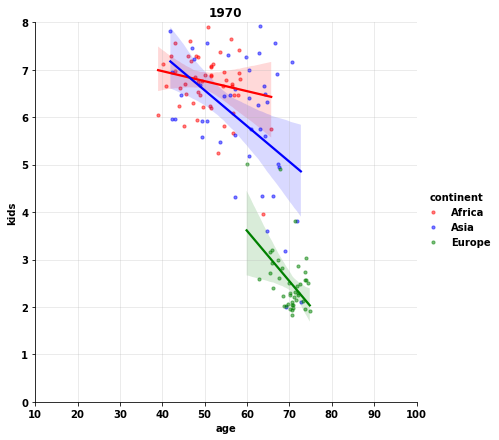

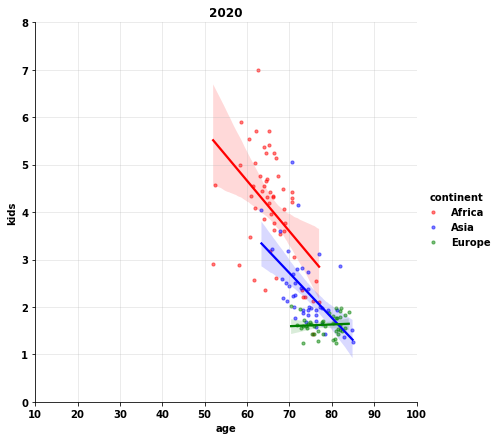

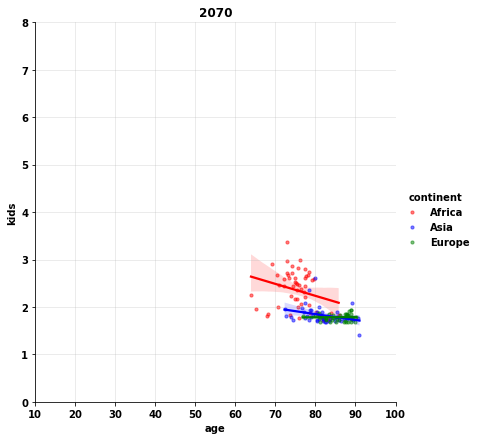

In [9]:
# select year (old function): single time point. observations = countries per continent
def select1YEAR(thisY):
    df = cList.merge(d_age[thisY], how='inner', left_index=True, right_index=True, suffixes=('', '_y'))    
    df = df.merge(d_kids[thisY], how='inner', left_index=True, right_index=True,suffixes=('', '_y'))    
    df.columns = ['continent', 'age', 'kids']
    return df


# list of time points
selY = ['1920', '1970', '2020', '2070']

# list of DFs with continent selection 
df_list = [select1YEAR(thisY)[select1YEAR(thisY)['continent'].isin(['Africa', 'Asia', 'Europe'])] for thisY in selY]  

# 4 scatterplots
for df, thisY in zip(df_list, selY):
    sns.lmplot(data=df, x='age', y='kids', hue = 'continent',palette = ['red', 'blue', 'green'], scatter_kws={'s': 10, 'alpha': .5}, height=6); 
    plt.xlim(10,100); plt.ylim(0,8); plt.grid(alpha=.3); plt.title(thisY)

__Interpretation?__ In general, life expectancy and birth rate are negatively correlated, meaning that families are small in countries where people live long (and vice versa). However, this correlation may change as the two variables change over time.

__Time-coure__ Look at the four scatterplots that were taken at different points in time. The association between life expectancy and birth rate emerges, persists and disappears. For example, in Europe, the effect was present in 1920 and 1970. It has disappeared today and is unlikely to re-appear in the future. Asia seems to lag behind Europe. No association between life expectancy and birth rate is present in 1920, but in 1970 and 2020; here, the association should attenuate some time between today and 50y into the future. Africa is a bit trickier to interpret based on these plots but it seems that the strength of the association between life expectancy and birth rate is currently at it\'s peak.  

--------
__Follow up A: Time course__ To illustrate how the two variables change over time, below graph plots life exp vs birth rate for all timepoints that are available in the dataset. Here, the observations are mean scores per continent. The bold circles indicates the current year (separately for the 3 investigated continents). 

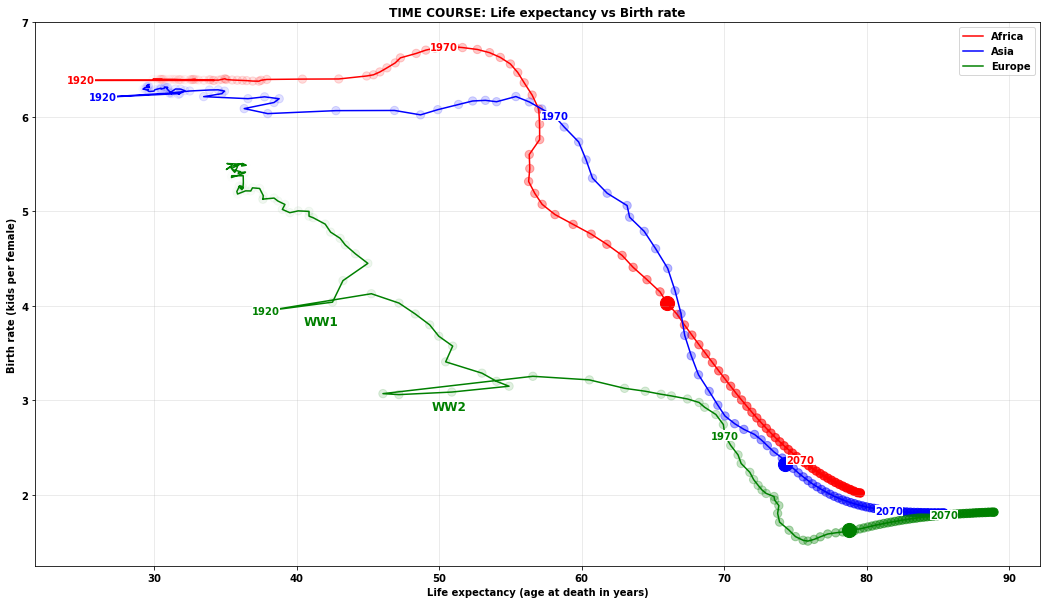

Fat circles indicate TODAY. Data points on the right side to the fat circle reflect predictions. Data downsampled (each data point represents the average of 2y). Note: Europe has an odd trajectory - ravaged by two wars, life expectancy recovered quickly after WW2 while birth rate remained fairly constant until the 1960ies and dropped in/after the 70ies.


In [10]:
# Plot life exp vs birth rate, separately per continent
def scatterOverTime(befrica, col, label):
    plt.plot(befrica.age, befrica.kids, '-', c = col,label = label)
    closestDataPointToToday = np.abs(befrica.index - datetime.datetime.now()).argmin()
    plt.scatter(befrica.iloc[closestDataPointToToday]['age'], befrica.iloc[closestDataPointToToday]['kids'], s=200, color=col)
    plt.scatter(befrica.age, befrica.kids, s=70, c=col,alpha= [x**3 for x in np.linspace(0.05,1,len(befrica))])

# Annnotate plot - print landmark years
def annotContinent(befrica, thisYear, col):
    closestDataPointToX = np.abs(befrica.index.year - thisYear).argmin()
    plt.annotate(str(thisYear), (befrica.iloc[closestDataPointToX].age, befrica.iloc[closestDataPointToX].kids), fontsize=10, color = col, ha = 'center', va='center', bbox=dict(facecolor='white', alpha=1, pad=0.15, ec='none'))

# plot figure with 3 continents 
fig = plt.figure(figsize=(18,10))
labelList = ['Africa', 'Asia', 'Europe']
colList = ['red', 'blue', 'green']
years2mark = [1920, 1970, 2070]
for x, col in zip(labelList, colList):
    befrica = new_df.xs(x, level=1, drop_level=True)
    befrica = befrica.resample('2Y').mean()
    scatterOverTime(befrica, col, x)    
    [annotContinent(befrica, thisYear, col) for thisYear in years2mark] # annotate    

# add annotations for wars (Europe)
plt.annotate('WW1', (40.5, 3.8), color = 'green', fontsize=12)
plt.annotate('WW2', (49.5, 2.9), color = 'green', fontsize=12)
    
plt.legend(); plt.grid(alpha=.3); plt.xlabel('Life expectancy (age at death in years)'); plt.ylabel('Birth rate (kids per female)')
plt.title('TIME COURSE: Life expectancy vs Birth rate'); plt.show()

print('Fat circles indicate TODAY. Data points on the right side to the fat circle reflect predictions. Data downsampled (each data point represents the average of 2y). Note: Europe has an odd trajectory - ravaged by two wars, life expectancy recovered quickly after WW2 while birth rate remained fairly constant until the 1960ies and dropped in/after the 70ies.')

--------
__Follow up B: Time course__ For each year, we could calculate the correlation between the two variables (life exp, birth rate), separately per continent. This would give us a better idea when the association emerged, how long it persisted and when it disappeared. This would also allow for comparing time-courses across Europe, Asia and Africa.

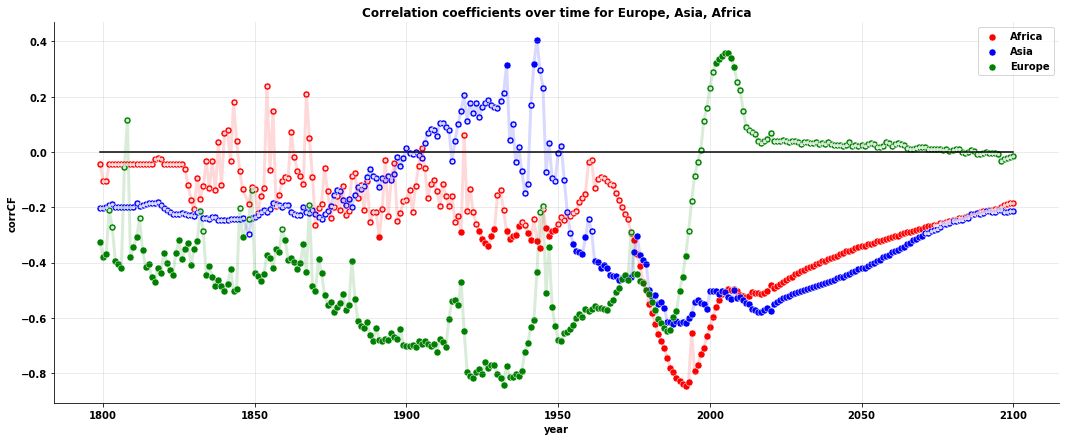

Filled and unfilled dots indicate correlation coefficients that are statistically significant vs non-significant, respectively. These correlation coefficients were calculated for each year, separately per continent (with countries as observations).


In [11]:
# for each year, calculate correlation coefficient separately per continent
continentCorrs= []
allY = [int(x) for x in d_kids.columns] # determine time range (skip missing year 1847)
for thisY in allY:
    dT = cList.merge(d_age[str(thisY)], how='inner', left_index=True, right_index=True)
    dT['kids'] = d_kids[str(thisY)]
    dT.columns = ['continent', 'age', 'kids']
    for idx,y in enumerate(dT.groupby('continent')):
        res = stats.linregress(y[1].dropna().age, y[1].dropna().kids)
        continentCorrs.append([thisY, y[0], res.rvalue, res.pvalue])

# create dataframe with year, continent, corrcoef, p-score and dichotomous variable coding whether corrcoef is significant
d_corr = pd.DataFrame(continentCorrs, columns = ['year', 'continent', 'corrCF', 'pscore'])
d_corr['is_significant'] = d_corr['pscore'].map(lambda x: 1 if x < 0.05 else 0)
d_corr.set_index(['year', 'continent'])
d_corr = d_corr[d_corr['continent'].isin(['Africa', 'Asia', 'Europe'])] 


fig = plt.figure(figsize=(18,7))
# plot zero line (x-axis)
sns.lineplot(x = allY, y = [0]*len(allY), color='black')
# dictionary for mapping continents with colors
cont2col_map = {'Africa': 'red', 'Asia': 'blue', 'Europe': 'green'}

# plot correlation coefficients
for x in d_corr.groupby('continent'):    
    sns.scatterplot(x = x[1].year, y = x[1].corrCF, color=cont2col_map[x[0]], s = 50, label = x[0])
    sns.lineplot(x = x[1].year, y = x[1].corrCF, color=cont2col_map[x[0]], linewidth=3, alpha=.15)

# mark non-significant correlation coefficients
for x in d_corr.groupby('continent'):    
    sns.scatterplot(x = x[1][x[1].is_significant == 0].year, y = x[1][x[1].is_significant == 0].corrCF, linestyle='None',marker='.', color='white')    

sns.despine(); plt.legend(); plt.grid(alpha=.3); plt.title('Correlation coefficients over time for Europe, Asia, Africa'); plt.show(); 
print('Filled and unfilled dots indicate correlation coefficients that are statistically significant vs non-significant, respectively. These correlation coefficients were calculated for each year, separately per continent (with countries as observations).') 


----------

__Conclusions?__ The association between life expectancy and birth rate follows different time-courses in Europe, Asia and Africa. 

In Europe, the negative correlation between the two variables is a thing of the past. It is unlikely to re-appear in this century (in fact, there has even been a rebound at around 2000 AD leading to a short-lived positive correlation). In Asia, correlations have been negative from the 1960ies on and will remain negative until about 2060. Similarly, in Africa, the effect has emerged in the 1970ies and it is projected to attenuate at about 2060. 

Why does the association between life expectancy and birth rate attenuate? This may have to do with the progression of the variables towards a stable plateau. Despite recent advances in health care, human lifespan may have hit its natural limit. Birth rate has an absolute minimum of zero, but more realistic may be a trend towards about 1.5 to 2 kids per woman (as momentarily observed in Europe). When the range of two variables is limited, there may just not be enough wiggle room for a robust correlation. 

__Famous last words__ The analyses shown here are correlational. It is perfectly possible - if not likely - that there are other variables that are behind this association (e.g., life expectancy could act as a proxy for the effectiveness of national health care systems).   